# Tutorial 2: Introduction to PyTorch

**Filled notebook:** 
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.ipynb)  
**Empty notebook:** 
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.ipynb)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial2/Introduction_to_PyTorch.ipynb)

**Goal**: Learn the basics of PyTorch (Tensors, Computation graph, etc.)

In [66]:
## Standard libraries
import os
import json
import math
import numpy as np 
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## The Basics of PyTorch

In [67]:
import torch
print("Using torch", torch.__version__)

Using torch 1.6.0


In [68]:
torch.manual_seed(42) # Setting the seed

### Tensors

Tensors are the PyTorch equivalent to Numpy arrays, with the addition to also have support for GPU acceleration (more on that later).
The name "tensor" is a generalization of concepts you know. For instance, a vector is a 1-D tensor, a matrix a 2-D tensor. When working with neural networks, we will use tensors of various shapes and number of dimensions.

Most common functions you know from numpy can be used on tensors as well. Actually, since numpy arrays are so similar to tensors, we can convert most tensors to numpy arrays (and back) but we don't need it too often.

#### Initialization

Let's first start by looking at different ways of creating a tensor. There are many possible options, the most simple one is to call `torch.Tensor` passing the desired shape as input argument:

In [25]:
x = torch.Tensor(2, 3, 4)
print(x)

tensor([[[1.8704e+20, 4.1962e-08, 1.2971e-11, 3.3462e+21],
         [1.0256e-08, 2.1478e-04, 1.3434e-05, 2.7303e-06],
         [3.4034e-06, 6.6645e-10, 3.1369e+27, 7.0800e+31]],

        [[3.1095e-18, 1.8590e+34, 7.7767e+31, 7.1536e+22],
         [3.3803e-18, 1.9421e+31, 2.7491e+20, 6.1949e-04],
         [1.7563e+25, 2.8896e+29, 1.2849e+31, 1.8395e+25]]])


The function `torch.Tensor` allocates memory for the desired tensor, but reuses any values that have already been in the memory. To directly assign values to the tensor during initialization, there are many alternatives including:

* `torch.zeros`: Creates a tensor filled with zeros
* `torch.ones`: Creates a tensor filled with ones
* `torch.rand`: Creates a tensor with random values uniformly sampled between 0 and 1
* `torch.randn`: Creates a tensor with random values sampled from a normal distribution with mean 0 and variance 1
* `torch.arange`: Creates a tensor containing the values $N,N+1,N+2,...,M$

In [27]:
x = torch.rand(2, 3, 4)
print(x)

tensor([[[0.0770, 0.1119, 0.5690, 0.3240],
         [0.9382, 0.0288, 0.0622, 0.5744],
         [0.1090, 0.2417, 0.5905, 0.5123]],

        [[0.9824, 0.9083, 0.9466, 0.6698],
         [0.1895, 0.4553, 0.5038, 0.5033],
         [0.7166, 0.1609, 0.7795, 0.6514]]])


You can obtain the shape of a tensor in the same way as in numpy (`x.shape`), or using the `.size` method:

In [33]:
shape = x.shape
print("Shape:", x.shape)

size = x.size()
print("Size:", size)

dim1, dim2, dim3 = x.size()
print("Size:", dim1, dim2, dim3)

Shape: torch.Size([2, 3, 4])
Size: torch.Size([2, 3, 4])
Size: 2 3 4


#### Operations

Most operations that exist in numpy, also exist in PyTorch. A full list of operations can be found in the [PyTorch documentation](https://pytorch.org/docs/stable/tensors.html#), but we will review the most important ones here.

The simplest operation is to add two tensors:

In [28]:
x1 = torch.rand(2, 3)
x2 = torch.rand(2, 3)
y = x1 + x2

print("X1", x1)
print("X2", x2)
print("Y", y)

X1 tensor([[0.0651, 0.4068, 0.2833],
        [0.3486, 0.2963, 0.2256]])
X2 tensor([[0.6283, 0.5690, 0.5801],
        [0.5114, 0.0117, 0.8664]])
Y tensor([[0.6934, 0.9758, 0.8634],
        [0.8601, 0.3080, 1.0920]])


Calling `x1 + x2` creates a new tensor containing the sum of the two inputs. However, we can also use in-place operations that mutate are applied directly on the memory of a tensor.

In [29]:
x1 = torch.rand(2, 3)
x2 = torch.rand(2, 3)
print("X1 (before)", x1)
print("X2 (before)", x2)

x2.add_(x1)
print("X1 (after)", x1)
print("X2 (after)", x2)

X1 (before) tensor([[0.1761, 0.0645, 0.8708],
        [0.4746, 0.8710, 0.4317]])
X2 (before) tensor([[0.9068, 0.8328, 0.6098],
        [0.6570, 0.3779, 0.8938]])
X1 (after) tensor([[0.1761, 0.0645, 0.8708],
        [0.4746, 0.8710, 0.4317]])
X2 (after) tensor([[1.0829, 0.8973, 1.4805],
        [1.1316, 1.2489, 1.3255]])


In-place operations are usually marked with a underscore postfix (e.g. "add_" instead of "add").

Another common operation aims at changing the shape of a tensor. A tensor of size (2,3) can be re-organized to any other shape with the same number of elements (e.g. a tensor of size (6), or (3,2), ...). In PyTorch, this operation is called `view`:

In [34]:
x = torch.arange(6)
print("X", x)

X tensor([0, 1, 2, 3, 4, 5])


In [35]:
x = x.view(2, 3)
print("X", x)

X tensor([[0, 1, 2],
        [3, 4, 5]])


In [36]:
x = x.permute(1, 0) # Swapping dimension 0 and 1
print("X", x)

X tensor([[0, 3],
        [1, 4],
        [2, 5]])


Other commonly used operations include matrix multiplications, which is essential for neural networks. Quite often, we have an input vector $\mathbf{x}$, which is transformed using a learned weight matrix $\mathbf{W}$. 

In [37]:
x = torch.arange(6)
x = x.view(2, 3)
print("X", x)

X tensor([[0, 1, 2],
        [3, 4, 5]])


In [40]:
W = torch.arange(9).view(3, 3) # We can also stack multiple operations in a single line
print("W", W)

W tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]])


In [41]:
h = torch.matmul(x, W) # Verify the result by calculating it by hand too!
print("h", h)

h tensor([[15, 18, 21],
        [42, 54, 66]])


#### Indexing

We often have the situation where we need to select a part of a tensor. Indexing works just like in numpy, so let's try it:

In [44]:
x = torch.arange(12).view(3, 4)
print("X", x)

X tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])


In [45]:
print(x[:, 1])   # Second column

tensor([1, 5, 9])


In [46]:
print(x[0])      # First row

tensor([0, 1, 2, 3])


In [47]:
print(x[:2, -1]) # First two rows, last column

tensor([3, 7])


In [48]:
print(x[1:3, :]) # Middle two rows

tensor([[ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])


### Dynamic Computation Graph and Backpropagation

One of the main reasons for using PyTorch is that we can automatically get **gradients/derivatives** of functions that we define. We will mainly use PyTorch for using Neural networks, and they are just fancy functions. If we use weight matrices in our function that we want to learn, then those are called the **parameters** or simply the **weights**.

If our Neural Network would output a single scalar value, we would talk about taking the **derivative**, but you will see that quite often we will have **multiple** output variables ("values"); in that case we talk about **gradients**. It's a more general term.

Given an input $\mathbf{x}$, we define our function by **manipulating** that input, usually by matrix-multiplications with weight matrices and additions with so-called bias vectors. As we manipulate our input, we are automatically creating a **computational graph**. This graph shows how to arrive at our output from our input. 
PyTorch is a **define-by-run** framework; this means that we can just do our manipulations, and PyTorch will keep track of that graph for us! Thus, we create dynamic computation graph along the way.

So, to recap: the only thing we have to do is to compute the **output**, and then we can ask PyTorch to automatically get the **gradients**. 

> **Note:  Why do we want gradients?** Consider that we have defined a function, a Neural Net, that is supposed to compute a certain output $y$ for an input vector $\mathbf{x}$. We then define an **error measure** that tells us how wrong our network is; how bad it is in predicting output $y$ from input $\mathbf{x}$. Based on this error measure, we can use the gradients to **update** the weights $\mathbf{W}$ that were responsible for the output, so that the next time we present input $\mathbf{x}$ to our network, the output will be closer to what we want.

The first thing we have to do is to specify which tensors require gradients. By default, when we create a tensor, it does not require gradients.

In [56]:
x = torch.ones((3,))
print(x.requires_grad)

False


We can change this for an existing tensor using the function `requires_grad_()` (underscore indicating that this is a in-place operation). Alternatively, when creating a tensor, you can pass the argument `requires_grad=True`.

In [57]:
x.requires_grad_(True)
print(x.requires_grad)

True


As an example, we will create a computation graph for the following function:

$$y = \frac{1}{|x|}\sum_i \left[(x_i + 2)^2 + 3\right]$$

We'll use $\mathbf{x}=[1,2,3]$ as our input.

In [59]:
x = torch.arange(3, dtype=torch.float32, requires_grad=True) # Only float tensors can have gradients
print("X", x)

X tensor([0., 1., 2.], requires_grad=True)


In [60]:
a = x + 2
b = a ** 2
c = b + 3
y = c.mean()
print("Y", y)

Y tensor(12.6667, grad_fn=<MeanBackward0>)


The created computation graph looks similar to the figure below:

<center style="width: 100%"><img src="pytorch_computation_graph.svg" width="200px"></center>

Each node has defined a function for calculating the gradients with respect to its inputs, `grad_fn`. You can see this when we printed the output tensor $y$. We can calculate the gradients by calling the function `backward()` on the last output:

In [61]:
y.backward()

`x.grad` will now contain the gradient $\partial y/ \partial x$, and this will say how a change in $x$ will affect output $y$:

In [62]:
print(x.grad)

tensor([1.3333, 2.0000, 2.6667])


We can also verify these gradients by hand. We will calculate the gradients using the chain rule, in the same way as PyTorch did it:

$$\frac{\partial y}{\partial x_i} = \frac{\partial y}{\partial c_i}\frac{\partial c_i}{\partial b_i}\frac{\partial b_i}{\partial a_i}\frac{\partial a_i}{\partial x_i}$$

Note that we have simplified this equation to index notation, and by using the fact that all operation besides the mean do not combine the elements in the tensor. The partial derivatives are:

$$
\frac{\partial a_i}{\partial x_i} = 1,\hspace{1cm}
\frac{\partial b_i}{\partial a_i} = 2\cdot a_i\hspace{1cm}
\frac{\partial c_i}{\partial b_i} = 1\hspace{1cm}
\frac{\partial y}{\partial c_i} = \frac{1}{3}
$$

Hence, with the input being $\mathbf{x}=[1,2,3]$, our gradients are $\partial y/\partial x=[4/3,2,8/3]$.

### GPU support

A crucial feature of PyTorch is the support of GPUs, short for Graphics Processing Unit. A GPU can perform many thousands of small operations in parallel, making it very well suitable for performing large matrix operations in neural networks. When comparing GPUs to CPUs, we can list the following main differences (credit: [Kevin Krewell, 2009](https://blogs.nvidia.com/blog/2009/12/16/whats-the-difference-between-a-cpu-and-a-gpu/)) 

<center style="width: 100%"><img src="comparison_CPU_GPU.png" width="700px"></center>

In case you are not familiar with GPUs, you can read up more details in this [NVIDIA blog post](https://blogs.nvidia.com/blog/2009/12/16/whats-the-difference-between-a-cpu-and-a-gpu/) or [here](https://www.intel.com/content/www/us/en/products/docs/processors/what-is-a-gpu.html). 

GPUs can accelerate the training of your network up to a factor of $100$ which is essential for large neural networks. PyTorch implements a lot of functionality for supporting GPUs (mostly those of NVIDIA due to the libraries [CUDA](https://developer.nvidia.com/cuda-zone) and [cuDNN](https://developer.nvidia.com/cudnn)). First, let's check whether you have a GPU available:

In [69]:
gpu_avail = torch.cuda.is_available()
print("Is the GPU available? %s" % str(gpu_avail))

Is the GPU available? True


If you have a GPU on your computer but the command above returns False, make sure you have the correct CUDA-version installed. On Google Colab, make sure to have selected a GPU in your runtime setup. 

By default, all tensors you create are stored on the CPU. We can push a tensor to the GPU by using the function `.to(...)`, or `.cuda()`. However, it is often a good practice to define a `device` object in your code which points to the GPU if you have one, and otherwise to the CPU. Then, you can write your code with respect to this device, and it allows you to run the same code on both a CPU-only system, and one with a GPU. Let's try it below. We can specify the device as follows: 

In [70]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Now let's create a tensor and push it to the device:

In [71]:
x = torch.zeros(2, 3)
x = x.to(device)
print("X", x)

X tensor([[0., 0., 0.],
        [0., 0., 0.]], device='cuda:0')


In case you have a GPU, you should now see the attribute `device='cuda:0'` being printed next to your tensor. We can also compare the runtime of a large matrix multiplication on the CPU with a operation on the GPU:

In [78]:
x = torch.randn(5000, 5000)

# CPU version
start_time = time.time()
_ = torch.matmul(x, x)
end_time = time.time()
print("CPU time: %5.4fs" % (end_time - start_time))

# GPU version
x = x.to(device)
start_time = time.time()
_ = torch.matmul(x, x)
end_time = time.time()
print("GPU time: %5.4fs" % (end_time - start_time))

CPU time: 0.1927s
GPU time: 0.0026s


## Learning by example: Continuous XOR

Now if we want to build a big neural network, we could specify all our parameters (weight matrices, bias vectors) using `Tensors` (with `requires_grad=True`), ask PyTorch to calculate the gradients and then adjust the parameters. But things can quickly get cumbersome if we have a lot of parameters. In PyTorch, there is a package called `torch.nn` that makes building neural networks more convenient. 

We will introduce the libraries, and all additional parts you might need to train a neural network in PyTorch, using a simple example classifier on a simple yet well known example: XOR. Hence, we will build a small binary classifier using a neural network, which separates the continuous input space into classes as below:

<center style="width: 100%"><img src="continuous_xor.svg" width="350px"></center>

### The model

The package `torch.nn` defines a series of useful classes like linear networks layers, activation functions, loss functions etc. A full list can be found [here](https://pytorch.org/docs/stable/nn.html). In case you need a certain network layer, check the documentation of the package before writing it yourself as it likely contains code for it already. We import it below:

In [6]:
import torch.nn as nn

Additionally to `torch.nn`, there is also `torch.nn.functional`. It contains functions that are used in network layers in contrast to `torch.nn` which defines them as `nn.Modules` (more on it below). The functional package is useful in many situations, so we import it as well here.

In [79]:
import torch.nn.functional as F

#### nn.Module

In PyTorch, a neural network is build up out of modules. Modules can contain other modules, and a neural network is considered to be a module itself as well. The basic template of a module is as follows:

In [81]:
class MyModule(nn.Module):
    
    def __init__(self):
        super().__init__()
        # Some init for my module
        
    def forward(self, x):
        # Function for performing the calculation of the module.
        pass

The forward function is where the computation of the module is taken place. In the init function, we usually create the parameters of the module, using `nn.Parameter`, or defining other modules that are used in the forward function. The backward calculation is done automatically.

#### Simple classifier
We can now make use of the pre-defined modules in the `torch.nn` package, and define our own small neural network. We will use a minimal network with one input layer, tanh as activation function, and a single output layer. In PyTorch, we can define this as follows:

In [82]:
class SimpleClassifier(nn.Module):
    
    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)
        
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x

For the examples in this notebook, we will use a tiny neural network with two input neurons and four hidden neurons. As we perform binary classification, we will use a single output neuron. Note that we do not apply a sigmoid on the output yet. This is because other functions, especially the loss, is more efficient and precise to calculate on the original outputs instead of the sigmoid output.

In [83]:
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)
# Printing a module shows all its submodules
print(model)

SimpleClassifier(
  (linear1): Linear(in_features=2, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)


The parameters of a module can be obtained by using its `parameters()` functions, or `named_parameters()` to get a name to each parameter object. For our small neural network, we have the following parameters:

In [84]:
for name, param in model.named_parameters():
    print("Parameter %s, shape %s" % (name, str(param.shape)))

Parameter linear1.weight, shape torch.Size([4, 2])
Parameter linear1.bias, shape torch.Size([4])
Parameter linear2.weight, shape torch.Size([1, 4])
Parameter linear2.bias, shape torch.Size([1])


### The data

* Explanation and intro to `torch.utils.data` library

In [9]:
import torch.utils.data as data

#### The dataset class

* Explanation of PyTorch's dataset class
* Implementation of XOR dataset class

In [10]:
class XORDataset(data.Dataset):
    
    def __init__(self, size, std=0.1):
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continuous_xor()
        
    
    def generate_continuous_xor(self):
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.long)
        data += self.std * torch.randn(data.shape)
        
        self.data = data
        self.label = label
        
    
    def __len__(self):
        return self.size
    
    
    def __getitem__(self, idx):
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

In [11]:
dataset = XORDataset(size=200)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 200
Data point 0: (tensor([-0.0230, -0.0510]), tensor(0))


In [12]:
def visualize_samples(data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]
    
    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

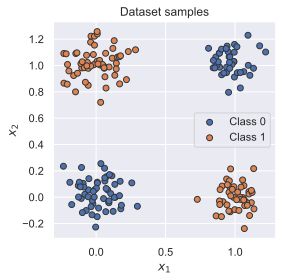

In [13]:
visualize_samples(dataset.data, dataset.label)
plt.show()

#### The data loader class

* Explanation of `torch.utils.data.DataLoader`
* How does batching work, and other relevant input parameters to the data loader

In [14]:
data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True)

In [15]:
data_inputs, data_labels = next(iter(data_loader))
print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)

Data inputs torch.Size([8, 2]) 
 tensor([[ 8.4399e-01,  1.0384e+00],
        [ 9.9803e-01, -9.4551e-02],
        [-6.8783e-02,  1.0779e+00],
        [ 1.3859e-01, -5.4517e-05],
        [-1.8904e-01,  1.1273e-01],
        [ 1.0390e+00, -1.7166e-02],
        [ 1.0379e+00,  8.2923e-01],
        [ 1.1044e+00, -1.3916e-01]])
Data labels torch.Size([8]) 
 tensor([0, 1, 1, 0, 0, 1, 0, 1])


### Optimization

#### Loss modules
* List of loss modules in PyTorch
* Use BinaryCrossEntropy for our example

In [16]:
loss_module = nn.BCEWithLogitsLoss()

#### Stochastic Gradient Descent
* `torch.optim` library
* Use simple SGD

In [17]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

### Training

#### A simple training loop

In [18]:
train_dataset = XORDataset(size=1000)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True)

In [19]:
def train_model(model, optimizer, data_loader, loss_module, num_epochs=100):
    model.train()
    model.to(device)
    for epoch in tqdm(range(num_epochs)):
        # Loop once over the training dataset
        for data_inputs, data_labels in data_loader:
            # Move input data to device (only strictly necessary if we use GPU)
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            
            # Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]
            
            # Calculate the loss
            loss = loss_module(preds, data_labels.float())
            
            # Perform backpropagation, and update parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [20]:
train_model(model, optimizer, train_data_loader, loss_module)

#### Logging

#### Saving a model

### Evaluation

In [21]:
test_dataset = XORDataset(size=500)
test_data_loader = data.DataLoader(test_dataset, batch_size=32, shuffle=False)

The accuracy metric is calculated as:

$$acc = \frac{\#\text{correct predictions}}{\#\text{all predictions}} = \frac{TP+TN}{TP+TN+FP+FN}$$

In [22]:
def eval_model(model, data_loader):
    model.to(device) # Not needed if model already on device
    model.eval()
    TP, num_exmps = 0., 0.
    with torch.no_grad():
        for data_inputs, data_labels in data_loader:
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            preds = torch.sigmoid(preds)
            pred_labels = (preds >= 0.5).long()
            TP += (pred_labels == data_labels).sum()
            num_exmps += data_labels.shape[0]
    acc = TP / num_exmps
    print("Accuracy of the model: %4.2f%%" % (100.0*acc))

In [23]:
eval_model(model, test_data_loader)

Accuracy of the model: 100.00%


#### Visualizing classification boundaries

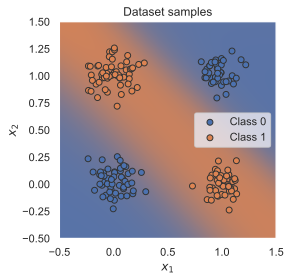

In [80]:
@torch.no_grad()
def visualize_classification(model, data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]
    
    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()
    
    model.to(device)
    c0 = torch.Tensor(to_rgba("C0")).to(device)
    c1 = torch.Tensor(to_rgba("C1")).to(device)
    x1 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    x2 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2)
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    preds = model(model_inputs)
    preds = torch.sigmoid(preds)
    output_image = preds * c0[None,None] + (1 - preds) * c1[None,None]
    output_image = output_image.cpu().numpy()
    plt.imshow(output_image, origin='upper', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)

visualize_classification(model, dataset.data, dataset.label)
plt.savefig("continuous_xor.svg")